<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-overview" data-toc-modified-id="Project-overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project overview</a></span></li><li><span><a href="#Key-imports-and-functions" data-toc-modified-id="Key-imports-and-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Key imports and functions</a></span></li><li><span><a href="#Data-import-and-preparation" data-toc-modified-id="Data-import-and-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data import and preparation</a></span><ul class="toc-item"><li><span><a href="#Standarizing-data" data-toc-modified-id="Standarizing-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Standarizing data</a></span></li><li><span><a href="#Transforming-data-for-RNNs" data-toc-modified-id="Transforming-data-for-RNNs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Transforming data for RNNs</a></span></li><li><span><a href="#Splitting-data-to-train-and-test-sets" data-toc-modified-id="Splitting-data-to-train-and-test-sets-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Splitting data to train and test sets</a></span></li></ul></li><li><span><a href="#Recurrent-Neural-Network-models" data-toc-modified-id="Recurrent-Neural-Network-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recurrent Neural Network models</a></span><ul class="toc-item"><li><span><a href="#Single-RNN-layer-model" data-toc-modified-id="Single-RNN-layer-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Single RNN layer model</a></span></li><li><span><a href="#Deep-RNN" data-toc-modified-id="Deep-RNN-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Deep RNN</a></span></li><li><span><a href="#Deep-RNN-with-GRU" data-toc-modified-id="Deep-RNN-with-GRU-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Deep RNN with GRU</a></span></li><li><span><a href="#Deep-RNN-with-LSTM" data-toc-modified-id="Deep-RNN-with-LSTM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Deep RNN with LSTM</a></span></li></ul></li><li><span><a href="#Results-summary" data-toc-modified-id="Results-summary-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results summary</a></span><ul class="toc-item"><li><span><a href="#RNN-models-comparison" data-toc-modified-id="RNN-models-comparison-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>RNN models comparison</a></span></li><li><span><a href="#Base-ML-models-and-RNN-comparison" data-toc-modified-id="Base-ML-models-and-RNN-comparison-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Base ML models and RNN comparison</a></span></li><li><span><a href="#Best-model-characteristic" data-toc-modified-id="Best-model-characteristic-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Best model characteristic</a></span></li></ul></li></ul></div>

# Project overview

The third and final stage of the project focuses on Recurent Neural Networks. As Recurent Neural Networks require specific format of input data - stacked 3D arrays, the first part will focus on transforming previously used data to correct format.After transforming data we will compare 4 different RNN architectures. 

Final part of this notebook compares best model from all stages of the project and summarizes characteristic of the best model. 

# Key imports and functions

In [1]:
import pandas as pd
import numpy as np
import random as random

# plotly standard imports
import plotly.graph_objs as go
import chart_studio.plotly as py
from datetime import datetime
from datetime import timedelta  

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras


# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.figure_factory as ff

In [2]:
def model_comparison_outputs_DNN(X_train, y_train, X_test, y_test, model):
    
    df_pred_train=prediction_df(X_train,y_train,model)
    df_pred_test=prediction_df(X_test,y_test,model)
    
    df_train_pr=precision_recall_curve(df_pred_train)
    df_test_pr=precision_recall_curve(df_pred_test)
    
    return df_pred_train,df_pred_test, df_train_pr, df_test_pr
    

from Custom_Functions import (
append_split_class, df_to_rnn_matrix, shuffle_arrays,
sequences_train_test_split, precision_recall_threshold,
precision_recall_curve, model_comparison_outputs,
prediction_df, plot_recall_surplus_train_test, plot_recall_surplus_train_test
)








def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points




n_steps = 9
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, 0, 2])

    
def prediction_df(X,y,model):
    y_pred = model.predict(X)
    df_pred=pd.DataFrame(y_pred,columns=["y_pred"])
    df_pred["y_true"]=pd.DataFrame(y) 
    df_pred["y_true_cl"]=binarize_labels(y,-0.5)
    df_pred["ones"]=1
    df_pred.sort_values(by="y_true", inplace=True)
    df_pred["true_rank"]=df_pred.ones.cumsum()
    df_pred.sort_values(by="y_pred", inplace=True)
    df_pred["pred_rank"]=df_pred.ones.cumsum()

    df_pred.drop(columns="ones",inplace=True)
    
    return(df_pred)

def binarize_labels(y, threshold):
    y=np.where(y<threshold,1,0)
    return(y)

# Data import and preparation

In [3]:
df=pd.read_excel("processed_data.xlsx")
df.drop(columns=['Unnamed: 0'],inplace=True)

df_max_period=df[["loan_ID","period"]].groupby("loan_ID").max()
df_max_period.reset_index(inplace=True)

df_max_period.rename(columns={'period':"period_max"},inplace=True)

df=df.merge(df_max_period, on="loan_ID")

## Standarizing data

In [4]:
payment_delay_std=df.payment_delay.std()
payment_delay_mean=df.payment_delay.mean()
completeness_mean=1



df["payment_delay_norm"]=(df["payment_delay"]-payment_delay_mean)/payment_delay_std
df["payment_completeness_norm"]=(df.payment_completeness-completeness_mean)

np.random.seed(51)
df=append_split_class(df, 0.8, 0.2)

df_test=df[df.test]
df_train=df[df.train]

df_test.shape

df_train.shape

df.columns

(7536, 35)

(29771, 35)

Index(['loan_ID', 'client_ID', 'sex', 'age', 'post_code', 'cash_payment',
       'initial_loan_value', 'installment_count', 'payout_date',
       'first_installment_date', 'installment', 'period', 'payment_value',
       'payment_date', 'cumulated_payments', 'expected_payment_date',
       'last_payment_period', 'last_payment_date', 'max_cumulated_payments',
       'payment_delay', 'month', 'payment_completeness', 'paid_ratio', 'year',
       'is_male', 'is_christmass_season', 'is_default', 'month_year',
       'date_bucket', 'period_max', 'payment_delay_norm',
       'payment_completeness_norm', 'train', 'test', 'val'],
      dtype='object')

## Transforming data for RNNs

To train RNNs we need to transform data used previously to a 3D array with dimensions equivalent to (number of samples, window size, number of features). As we saw that payment delay and payment completeness are the most important features, we will focus on these 2 features for our X data. 

We will focus on series with window size of 10. As some clients have more than 10 payments, we will augment our training dataset by creating multiple vectors for these clients - for example is a client has 13 payments, we can create 4 separate vectors from the following installment indexes: 1-10,2-11,3-12,4-13. 

In [5]:
def df_to_rnn_matrix_base(df, min_payments,RNN_features):

    df_rnn=df[df.period_max>=min_payments][RNN_features]
    df_rnn=df_rnn[df_rnn.period<=min_payments]
    ID_list=df_rnn.loan_ID.unique()
    
    for loan_id in ID_list:
        
        
        X_temp=df_rnn[df_rnn.loan_ID==loan_id][RNN_features[2:]].values
        X_temp=X_temp.reshape((1,X_temp.shape[0],X_temp.shape[1]))
        

        
        
        if loan_id==ID_list[0]:
            X=X_temp
        else:
            X=np.concatenate([X, X_temp], 0)
        
    return(X)


RNN_features=['loan_ID',"period", 'payment_delay_norm', 'payment_completeness_norm',]

RNN_features

['loan_ID', 'period', 'payment_delay_norm', 'payment_completeness_norm']

In [6]:
#Defining minimal window size and client maturity for data augmentation
window_size=10
min_len=10

In [7]:
X_train=df_to_rnn_matrix_base(df_train,min_len,RNN_features)
X_train_aug=df_to_rnn_matrix(df_train,min_len,RNN_features,window_size)
X_test=df_to_rnn_matrix_base(df_test,min_len,RNN_features)

In [8]:
X_train.shape
X_train_aug.shape
X_test.shape

(1286, 10, 2)

(5488, 10, 2)

(345, 10, 2)

## Splitting data to train and test sets 

When splitting data after augmentation, we need to make sure that one client can only be present in one of the sets. If we create multiple X entries for one client and some of them were used in train and test set, that would influence the performance making it missleading - the training algorithm might have seen the actual time serie it would need to predict during testing. 

After having selected vectors of 10 periods, we need to split the last payment completeness entry as y, leaving the previous 9 periods as X. 


In [9]:
X_train_aug, y_train_aug=sequences_train_test_split(X_train_aug,min_len)
X_train, y_train=sequences_train_test_split(X_train,min_len)
X_test, y_test=sequences_train_test_split(X_test,min_len)

In [10]:
X_train.shape
X_test.shape
X_train_aug.shape

(1286, 9, 2)

(345, 9, 2)

(5488, 9, 2)

We need to make sure that training and testing sets have similar shares of defaults, as large differences in class composition would make it harder to compare performance for test and train set. 

In [11]:
y_train.mean()
y_test.mean()

-0.1234040329305214

-0.12268138018699748

y labels need to be changed into binary classes in order to make training and performance assesment easier. 

In [12]:
threshold=0.2-1
y_test, y_train,y_train_aug=binarize_labels(y_test,threshold),binarize_labels(y_train,threshold),binarize_labels(y_train_aug,threshold)

In [13]:
y_train.mean()
y_test.mean()
y_train_aug.mean()

0.12130637636080871

0.12753623188405797

0.12955539358600582

In [14]:
X_train_aug=X_train
y_train_aug=y_train

# Recurrent Neural Network models

## Single RNN layer model

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
input_dim=X_train.shape[1:]

In [16]:
Base_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(input_shape=[input_dim[0],input_dim[1]],units=50, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

Base_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2650      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________


First analyzed RNN model is created using single RNN layer together with 1 other fully connected layer. Droput is added for regularization.

In [17]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Base_rnn.compile(loss="mse", optimizer=optimizer)

In [18]:
history = Base_rnn.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 5s 4ms/sample - loss: 0.2834 - val_loss: 0.2622
Epoch 2/50
1286/1286 [==============================] - 0s 310us/sample - loss: 0.2685 - val_loss: 0.2509
Epoch 3/50
1286/1286 [==============================] - 0s 262us/sample - loss: 0.2568 - val_loss: 0.2426
Epoch 4/50
1286/1286 [==============================] - 0s 270us/sample - loss: 0.2501 - val_loss: 0.2353
Epoch 5/50
1286/1286 [==============================] - 0s 263us/sample - loss: 0.2415 - val_loss: 0.2282
Epoch 6/50
1286/1286 [==============================] - 0s 265us/sample - loss: 0.2332 - val_loss: 0.2209
Epoch 7/50
1286/1286 [==============================] - 0s 264us/sample - loss: 0.2277 - val_loss: 0.2123
Epoch 8/50
1286/1286 [==============================] - 0s 263us/sample - loss: 0.2171 - val_loss: 0.2003
Epoch 9/50
1286/1286 [==============================] - 0s 262us/sample - loss: 0.2065 - val_loss: 0.1821
E

In [19]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

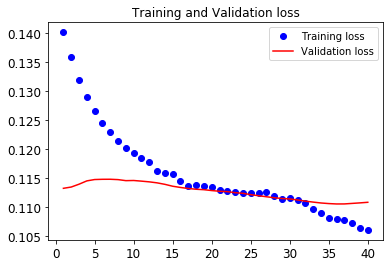

In [20]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [21]:
rnn_pred_train,rnn_pred_test,rnn_pr_train,rnn_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Base_rnn)

In [22]:
plot_recall_surplus_train_test(rnn_pr_train,rnn_pr_test)

One Layer RNN seems to overfitt training data and performs quite poorly on test set. Let's see if a more advanced architecture will improve the performance. 

## Deep RNN

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

In [24]:
Deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(input_shape=[input_dim[0],input_dim[1]],units=40, activation="relu", return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

Combining two RNN layers together, using BatchNormalization to avoid exploding gradients and overfitting should provide better results. The deeper network should perform better. 

In [25]:
Deep_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 9, 40)             1720      
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                1220      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [26]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_rnn.compile(loss="binary_crossentropy", optimizer=optimizer)

In [27]:
history = Deep_rnn.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 3s 2ms/sample - loss: 0.8197 - val_loss: 0.7039
Epoch 2/50
1286/1286 [==============================] - 1s 668us/sample - loss: 0.7765 - val_loss: 0.6842
Epoch 3/50
1286/1286 [==============================] - 1s 506us/sample - loss: 0.7319 - val_loss: 0.6600
Epoch 4/50
1286/1286 [==============================] - 1s 528us/sample - loss: 0.7110 - val_loss: 0.6329
Epoch 5/50
1286/1286 [==============================] - 1s 514us/sample - loss: 0.6767 - val_loss: 0.6064
Epoch 6/50
1286/1286 [==============================] - 1s 693us/sample - loss: 0.6606 - val_loss: 0.5784
Epoch 7/50
1286/1286 [==============================] - 1s 583us/sample - loss: 0.6297 - val_loss: 0.5504
Epoch 8/50
1286/1286 [==============================] - 1s 597us/sample - loss: 0.6092 - val_loss: 0.5258
Epoch 9/50
1286/1286 [==============================] - 1s 474us/sample - loss: 0.5739 - val_loss: 0.4990
E

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

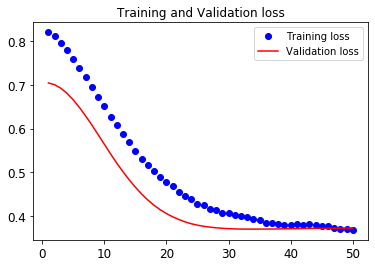

In [29]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

In [30]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

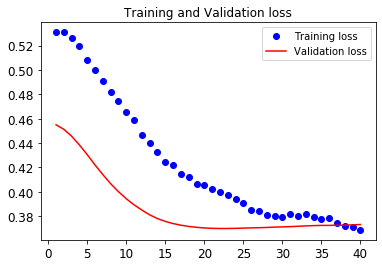

In [31]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

Training curves seem to perform better, with constant decrease in both Training and Validation loss. Slight increase in Validation loss after epoch 30 might suggest that we were training the network for too long. 

In [32]:
drnn_pred_train,drnn_pred_test,drnn_pr_train,drnn_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_rnn)

plot_recall_surplus_train_test(drnn_pr_train,drnn_pr_test)

Results for deep RNN are clearly much better than for the initial RNN model. Recall Surplus for test and train data behave similarly within lower Positives Share ranges, the gap increases slightly in higher ranges showing some overfitting. 

## Deep RNN with GRU

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

Changing simple RNN cells for GRU should help to spot patterns within data better, due to use of memory cells. BatchNorm together with drop out was used for normalization. 

In [34]:
Deep_GRU = keras.models.Sequential([
    keras.layers.GRU(input_shape=[input_dim[0],input_dim[1]],units=40,activation="relu",return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.GRU(20),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

Deep_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 9, 40)             5280      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                3720      
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [35]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_GRU.compile(loss="mse", optimizer=optimizer)

In [36]:
history = Deep_GRU.fit(X_train_aug, y_train_aug, epochs=50,
                    validation_data=(X_test, y_test))

Train on 1286 samples, validate on 345 samples
Epoch 1/50
1286/1286 [==============================] - 12s 9ms/sample - loss: 0.3140 - val_loss: 0.2506
Epoch 2/50
1286/1286 [==============================] - 1s 757us/sample - loss: 0.2797 - val_loss: 0.2428
Epoch 3/50
1286/1286 [==============================] - 1s 783us/sample - loss: 0.2565 - val_loss: 0.2350
Epoch 4/50
1286/1286 [==============================] - 1s 797us/sample - loss: 0.2378 - val_loss: 0.2261
Epoch 5/50
1286/1286 [==============================] - 1s 866us/sample - loss: 0.2253 - val_loss: 0.2154
Epoch 6/50
1286/1286 [==============================] - 1s 819us/sample - loss: 0.2108 - val_loss: 0.2042
Epoch 7/50
1286/1286 [==============================] - 1s 787us/sample - loss: 0.1935 - val_loss: 0.1926
Epoch 8/50
1286/1286 [==============================] - 1s 712us/sample - loss: 0.1886 - val_loss: 0.1825
Epoch 9/50
1286/1286 [==============================] - 1s 714us/sample - loss: 0.1807 - val_loss: 0.1728


In [37]:
loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Text(0.5, 1.0, 'Training and Validation loss')

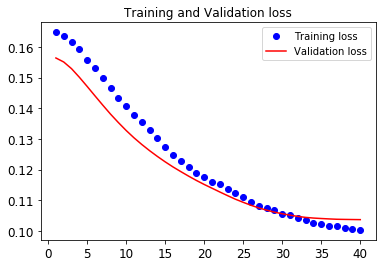

In [38]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

Training curve for all epochs shows contant decrease of both train and validation loss. We stopped training after 50 epochs, as validation loss was reaching plateau and we wanted to avoid overfitting. 

In [39]:
gru_pred_train,gru_pred_test,gru_pr_train,gru_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_GRU)

plot_recall_surplus_train_test(gru_pr_train,gru_pr_test)

Performance of RNN model with GRU cells is best so far both in terms of nearly same Recall Surplus Curve performance on both train and test set and overall Recall Surplus maximums of nearly 0.3. Both these characteristics mean, that this model is best in terms of performance and it should also generalize well as we have no signs of overfitting. 

## Deep RNN with LSTM

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)

Deep_LSTM = keras.models.Sequential([
    keras.layers.LSTM(input_shape=[input_dim[0],input_dim[1]],units=40,activation="relu",return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(units=10, activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid")
])

In [41]:
Deep_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 40)             6880      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 40)             160       
_________________________________________________________________
dropout (Dropout)            (None, 9, 40)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                1220      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 8,481
Trainable params: 8,401
Non-trainable params: 80
_____________________________________________________

In [42]:
optimizer = keras.optimizers.Adam(lr=0.0001)
Deep_LSTM.compile(loss="mse", optimizer=optimizer)

In [43]:
history = Deep_LSTM.fit(X_train_aug, y_train_aug, epochs=100,
                    validation_data=(X_test, y_test))

loss = history.history['loss'][10:]
val_loss = history.history['val_loss'][10:]

Train on 1286 samples, validate on 345 samples
Epoch 1/100
1286/1286 [==============================] - 4s 3ms/sample - loss: 0.2782 - val_loss: 0.2555
Epoch 2/100
1286/1286 [==============================] - 1s 671us/sample - loss: 0.2500 - val_loss: 0.2464
Epoch 3/100
1286/1286 [==============================] - 1s 718us/sample - loss: 0.2254 - val_loss: 0.2362
Epoch 4/100
1286/1286 [==============================] - 1s 792us/sample - loss: 0.2051 - val_loss: 0.2242
Epoch 5/100
1286/1286 [==============================] - 1s 764us/sample - loss: 0.1884 - val_loss: 0.2106
Epoch 6/100
1286/1286 [==============================] - 1s 773us/sample - loss: 0.1763 - val_loss: 0.1964
Epoch 7/100
1286/1286 [==============================] - 1s 1ms/sample - loss: 0.1606 - val_loss: 0.1813
Epoch 8/100
1286/1286 [==============================] - 1s 868us/sample - loss: 0.1508 - val_loss: 0.1673
Epoch 9/100
1286/1286 [==============================] - 1s 767us/sample - loss: 0.1393 - val_loss: 0

1286/1286 [==============================] - 1s 703us/sample - loss: 0.0957 - val_loss: 0.1036
Epoch 77/100
1286/1286 [==============================] - 1s 738us/sample - loss: 0.0960 - val_loss: 0.1035
Epoch 78/100
1286/1286 [==============================] - 1s 709us/sample - loss: 0.0953 - val_loss: 0.1038
Epoch 79/100
1286/1286 [==============================] - 1s 657us/sample - loss: 0.0952 - val_loss: 0.1037
Epoch 80/100
1286/1286 [==============================] - 1s 663us/sample - loss: 0.0953 - val_loss: 0.1036
Epoch 81/100
1286/1286 [==============================] - 1s 758us/sample - loss: 0.0962 - val_loss: 0.1035
Epoch 82/100
1286/1286 [==============================] - 1s 781us/sample - loss: 0.0962 - val_loss: 0.1034
Epoch 83/100
1286/1286 [==============================] - 1s 827us/sample - loss: 0.0947 - val_loss: 0.1032
Epoch 84/100
1286/1286 [==============================] - 1s 796us/sample - loss: 0.0954 - val_loss: 0.1036
Epoch 85/100
1286/1286 [=================

Text(0.5, 1.0, 'Training and Validation loss')

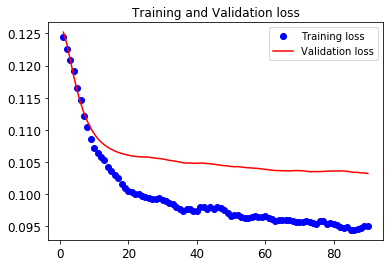

In [44]:
epochs = range(1, len(loss)+1)
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r-', label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

lstm_pred_train,lstm_pred_test,lstm_pr_train,lstm_pr_test= model_comparison_outputs_DNN(X_train,y_train, X_test, y_test, Deep_LSTM)

plot_recall_surplus_train_test(lstm_pr_train,lstm_pr_test)

LTSM model shows good performance but overfitts the data much more than GRU model. Due to complexity of LSTM cells and relatively small sample size, the training of this network was more difficult. The LSTM based RNN could perform much better if we had more data. 

# Results summary

## RNN models comparison

In [45]:
    trace0=go.Scatter(
            y=rnn_pr_test.recall-rnn_pr_test.positives_share,
            x=rnn_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Single RNN layer"
        )
    
    trace1=go.Scatter(
            y=drnn_pr_test.recall-drnn_pr_test.positives_share,
            x=drnn_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Deep RNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall-gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=lstm_pr_test.recall-lstm_pr_test.positives_share,
            x=lstm_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="RNN with LSTM cells"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall surplus in relation to Postives Share",
            yaxis=dict(title="Recall surplus"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

RNN model with two layers of GRU cells outperforms all other architectures across nearly whole range of Positives share. It is also first architecture to have >0.25 Recall Surplus across majority of Positives Share range. 

## Base ML models and RNN comparison

In [46]:
RF_pr_test=pd.read_excel("Random_Forest_summary.xlsx")

DNN_test=pd.read_excel("DNN_summary.xlsx")

Ensemble_pr_test=pd.read_excel("Ensemble_summary.xlsx")

In [47]:
    trace0=go.Scatter(
            y=RF_pr_test.recall-RF_pr_test.positives_share,
            x=RF_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random Forest Classifier"
        )
    
    trace1=go.Scatter(
            y=DNN_test.recall-DNN_test.positives_share,
            x=DNN_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Fully connected DNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall-gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=Ensemble_pr_test.recall-Ensemble_pr_test.positives_share,
            x=Ensemble_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="Ensemble Model"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall surplus in relation to Postives Share",
            yaxis=dict(title="Recall surplus"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

Comparison of 4 best model, shows that they are quite similar in terms of performance, however RNN model with GRU cells has the edge over other models in nearly all ranges and has less fluctuations that other models, especially in lower ranges of Positives Share.

In [48]:
    trace0=go.Scatter(
            y=RF_pr_test.recall,
            x=RF_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random Forest Classifier"
        )
    
    trace1=go.Scatter(
            y=DNN_test.recall,
            x=DNN_test.positives_share,
            mode='lines',
            marker=dict(
            color="red",
            size=5,
            opacity=0.5
            ),
            name="Fully connected DNN"
        )
    
    trace2=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace3=go.Scatter(
            y=Ensemble_pr_test.recall,
            x=Ensemble_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="yellow",
            size=5,
            opacity=0.5
            ),
            name="Ensemble Model"
        )

    



    data=[trace0, trace1,trace2,trace3]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall in relation to Postives Share",
            yaxis=dict(title="Recall"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.76,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

Comparing graphs of Recall and Recall Surplus, we can see that Recall Surplus graph is easier to analyse, as it is easier to notice maximums. The Recall graph makes reading performance harder as all models' Recall grow constantly together with Postives Share. 

## Best model characteristic

In [49]:
    trace0=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="RNN with GRU cells"
        )

    trace1=go.Scatter(
            y=np.ones(gru_pr_test.positives_share.shape)*0.835,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="black",
            size=5,
            opacity=0.5
            ),
            name="Bayes unavoidable error"
        )

    trace2=go.Scatter(
            y=gru_pr_test.positives_share,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Random screening"
        )

    



    data=[trace0, trace1,trace2]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Recall in relation to Postives Share",
            yaxis=dict(title="Recall"),
            xaxis=dict(title="Positives share", range=[0,0.4]),
            legend=dict(
                x=0.73,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

For the best model, Recall is closing the gap to maximum possible performance (taking into consideration unavoidable error).  In range of Positives Share higher than 30%, there is only 20 p.p. gap, which means that we can still flag majority of risky clients. 

In [50]:
    trace0=go.Scatter(
            y=gru_pr_test.recall,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="green",
            size=5,
            opacity=0.5
            ),
            name="Recall"
        )



    trace1=go.Scatter(
            y=gru_pr_test.precission,
            x=gru_pr_test.positives_share,
            mode='lines',
            marker=dict(
            color="blue",
            size=5,
            opacity=0.5
            ),
            name="Precision"
        )

    



    data=[trace0, trace1]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Precision and Recall Curve",
            yaxis=dict(title=""),
            xaxis=dict(title="Positives share",range=[0.015,0.4]),
            legend=dict(
                x=0.85,
                y=0,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None


        )))
    iplot(figure)

Precision and Recall curves, show that the best Recall to Precision balance can be found within 10%-15% Positives Share range. For lower Positives Share recall is too low, while for higher ranges, we can see rapid drop in Precision, while Recall growth stagnates. 

In [51]:
gru_pred_test["risk_category"]=pd.qcut(gru_pred_test.y_pred, 5, labels=["safe", "low risk", "moderate risk","high risk","very high risk"])

In [52]:
risk_performance=gru_pred_test.groupby("risk_category").y_true.mean().reset_index()

In [53]:
risk_performance["default_count"]=gru_pred_test.groupby("risk_category").y_true.sum().values

In [54]:
risk_performance["share_of_defaults"]=risk_performance["default_count"]/gru_pred_test.y_true.sum()

In [55]:
fig = go.Figure(data=[
    go.Bar(name='Default Probability', x=risk_performance.risk_category, y=risk_performance.y_true),
    go.Scatter(
        x=risk_performance.risk_category,
        y=np.ones(5)*gru_pred_test.y_true.mean(),
        name='Portfolio average')
    
])

In [56]:
fig.update_layout(barmode='group',yaxis=dict(title="Default Probability"), legend=dict(
                x=0.1,
                y=1,
                traceorder="normal",
                font=dict(
                    family="sans-serif",
                    size=12,
                    color="black"
                ),
            bgcolor=None))

To check model performance in flagging risky clients, all test clients were split into 5 buckets, grouped by their prediction of default probability. For each of these groups, actual default data has been averaged, to see what share of clients within each group actually defaulted. 

We can see, that model does relatively well in predicting the safest and highest risk clients - their probability of default vary nearly 10 times. On the other hand, the 3 middle groups behave in a similar manner. 

In [58]:
fig = go.Figure(data=[
    go.Bar(name='Share of all defaults within risk category', x=risk_performance.risk_category, y=risk_performance["share_of_defaults"]),
]);


# Change the bar mode
fig.update_layout(barmode='group',yaxis=dict(title="% of total portfolio defaults"),)

Risk segmentation based on model prediction is performing quite well, as we are able to segment nearly 50% of all defaults within highest risk category, composed out of only 20% of clients. 